In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATASET_ROOT = "/content/drive/MyDrive/EndoscopicBladderTissue"
print("Dataset path:", DATASET_ROOT)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset path: /content/drive/MyDrive/EndoscopicBladderTissue


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

DATASET_PATH = "/content/drive/MyDrive/EndoscopicBladderTissue"
SPLIT_PATH = "/content/dataset_split"

if os.path.exists(SPLIT_PATH):
    shutil.rmtree(SPLIT_PATH)

os.makedirs(SPLIT_PATH)
os.makedirs(f"{SPLIT_PATH}/train")
os.makedirs(f"{SPLIT_PATH}/val")
os.makedirs(f"{SPLIT_PATH}/test")

classes = os.listdir(DATASET_PATH)

for cls in classes:
    src = os.path.join(DATASET_PATH, cls)
    if not os.path.isdir(src):
        continue

    imgs = os.listdir(src)

    train_files, temp = train_test_split(imgs, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(temp, test_size=0.5, random_state=42)

    for split_name, split_files in zip(
        ["train", "val", "test"],
        [train_files, val_files, test_files]
    ):
        dst = f"{SPLIT_PATH}/{split_name}/{cls}"
        os.makedirs(dst)

        for img in split_files:
            shutil.copy(os.path.join(src, img), dst)

print("Dataset split created successfully!")


Dataset split created successfully!


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_ds = datasets.ImageFolder(f"{SPLIT_PATH}/train", transform_train)
val_ds   = datasets.ImageFolder(f"{SPLIT_PATH}/val", transform_test)
test_ds  = datasets.ImageFolder(f"{SPLIT_PATH}/test", transform_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)
test_loader  = DataLoader(test_ds, batch_size=32)

classes = train_ds.classes
print("Classes:", classes)



Classes: ['HGC', 'LGC', 'NST', 'NTL']


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN17(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(),
            nn.Conv2d(512, 256, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.fc(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN17(num_classes=len(classes)).to(device)
model


CNN17(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), paddi

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", device)

model = CNN17().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Using: cuda


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

EPOCHS = 51

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(EPOCHS):
    model.train()
    correct = 0
    total = 0
    running_loss = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, pred = outputs.max(1)
        total += labels.size(0)
        correct += pred.eq(labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    correct = 0
    total = 0
    running_loss = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, pred = outputs.max(1)
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()

    val_acc = 100 * correct / total
    val_loss = running_loss / len(val_loader)
    val_accs.append(val_acc)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


Epoch 1/51 | Train Acc: 86.78% | Val Acc: 86.69%
Epoch 2/51 | Train Acc: 88.00% | Val Acc: 87.83%
Epoch 3/51 | Train Acc: 87.43% | Val Acc: 87.07%
Epoch 4/51 | Train Acc: 88.65% | Val Acc: 91.25%
Epoch 5/51 | Train Acc: 87.67% | Val Acc: 90.49%
Epoch 6/51 | Train Acc: 89.63% | Val Acc: 89.73%
Epoch 7/51 | Train Acc: 88.82% | Val Acc: 88.97%
Epoch 8/51 | Train Acc: 88.16% | Val Acc: 87.83%
Epoch 9/51 | Train Acc: 89.55% | Val Acc: 92.40%
Epoch 10/51 | Train Acc: 89.71% | Val Acc: 92.78%
Epoch 11/51 | Train Acc: 88.98% | Val Acc: 89.35%
Epoch 12/51 | Train Acc: 89.96% | Val Acc: 91.25%
Epoch 13/51 | Train Acc: 90.78% | Val Acc: 91.25%
Epoch 14/51 | Train Acc: 91.51% | Val Acc: 93.54%
Epoch 15/51 | Train Acc: 91.67% | Val Acc: 90.87%
Epoch 16/51 | Train Acc: 91.92% | Val Acc: 89.35%
Epoch 17/51 | Train Acc: 92.41% | Val Acc: 91.63%
Epoch 18/51 | Train Acc: 90.94% | Val Acc: 91.25%
Epoch 19/51 | Train Acc: 92.24% | Val Acc: 93.92%
Epoch 20/51 | Train Acc: 91.67% | Val Acc: 91.63%
Epoch 21/

In [ ]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"Test Accuracy: {correct/total*100:.2f}%")


Test Accuracy: 93.61%


In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import torch

img_path = "/content/drive/MyDrive/EndoscopicBladderTissue/HGC/case_002_pt_003_frame_0009.png"

img = Image.open(img_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

img = transform(img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(img)
    _, pred = output.max(1)

classes = ["HGC", "LGC", "NST", "NTL"]
print("Predicted Class:", classes[pred.item()])


Predicted Class: NTL


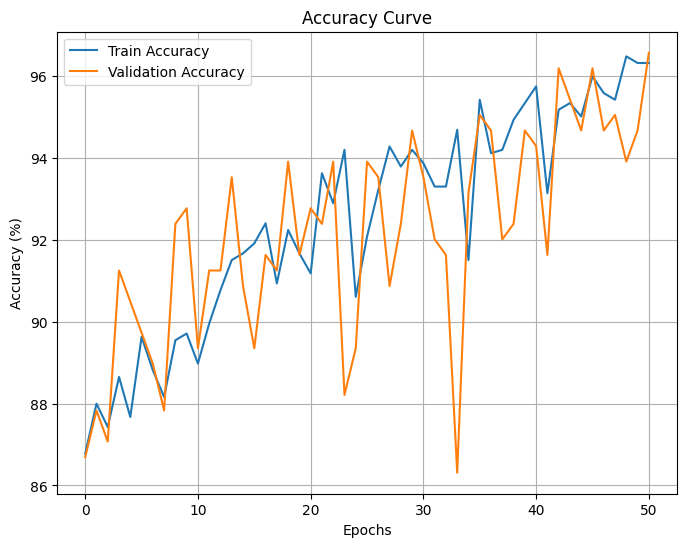

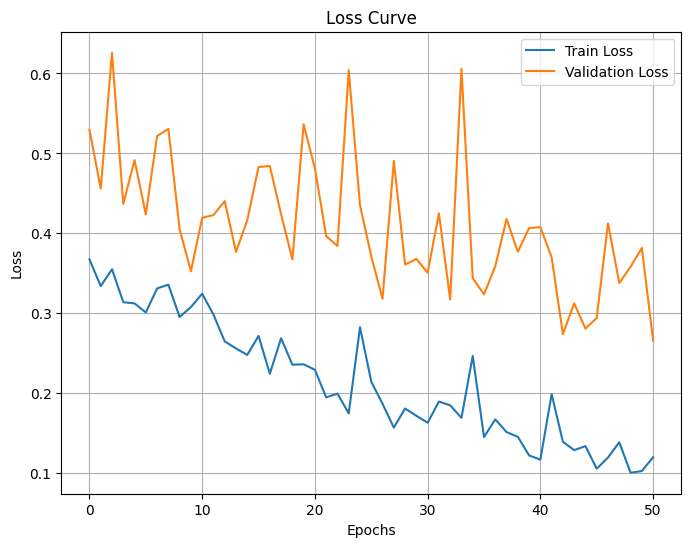

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()


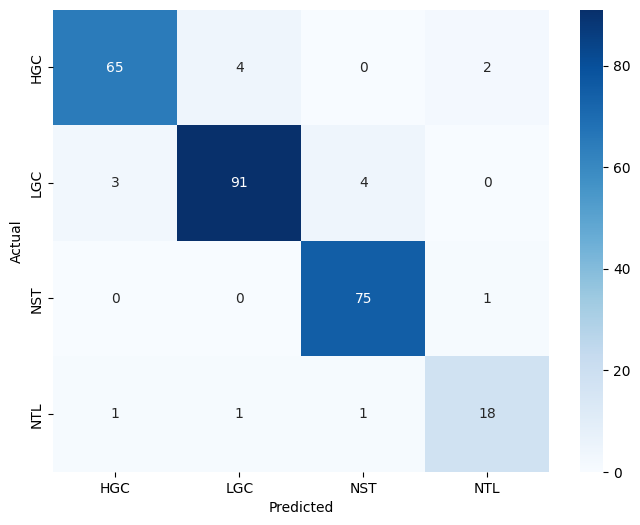

              precision    recall  f1-score   support

         HGC       0.94      0.92      0.93        71
         LGC       0.95      0.93      0.94        98
         NST       0.94      0.99      0.96        76
         NTL       0.86      0.86      0.86        21

    accuracy                           0.94       266
   macro avg       0.92      0.92      0.92       266
weighted avg       0.94      0.94      0.94       266



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

model.eval()
true_labels = []
pred_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = outputs.max(1)

        true_labels.extend(labels.numpy())
        pred_labels.extend(preds.cpu().numpy())

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(true_labels, pred_labels, target_names=classes))


In [ ]:
# best model already saved as best_bladder17.pth
# save final model too
torch.save(model.state_dict(), "final_bladder17.pth")
print("Saved: best_bladder17.pth and final_bladder17.pth")

# Save class names
import json
with open("classes.json", "w") as f:
    json.dump(classes, f)
print("Saved classes.json")


Saved: best_bladder17.pth and final_bladder17.pth
Saved classes.json


In [ ]:
!ls -lh


total 36M
drwxr-xr-x 5 root root 4.0K Dec  5 10:37 bladder_dataset
-rw-r--r-- 1 root root   28 Dec  5 12:00 classes.json
drwxr-xr-x 5 root root 4.0K Dec  5 10:57 dataset_split
drwx------ 5 root root 4.0K Dec  5 10:25 drive
-rw-r--r-- 1 root root  36M Dec  5 12:00 final_bladder17.pth
drwxr-xr-x 1 root root 4.0K Nov 20 14:30 sample_data


In [ ]:
from google.colab import files
files.download("final_bladder17.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>